In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 12})

from scipy import signal 
from scipy import stats
import itertools
import seaborn as sns
import statsmodels.api as sm
import random

In [2]:
import pickle
import json
json_open = open('../../dj_local_conf.json', 'r') 
config = json.load(json_open)

import datajoint as dj
dj.config['database.host'] = config["database.host"]
dj.config['database.user'] = config ["database.user"]
dj.config['database.password'] = config["database.password"]
dj.conn().connect()

from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf
from pipeline.plot import unit_psth
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice
from pipeline import psth_foraging
from pipeline import util
from pipeline.model import bandit_model

/home/map/.local/lib/python3.6/site-packages/pymysql/_auth.py:8: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography.hazmat.backends import default_backend


Connecting pochen@datajoint.mesoscale-activity-map.org:3306


### Simulated neurons

In [3]:
def gen_random_walk_neuron(n_trial, diff_para=0.1, f_1=2.5, 
                           seed=None, plot=False):
    if seed:
        np.random.seed(seed)

    firing_rate = np.zeros(n_trial)
    firing_rate[0] = np.random.uniform(f_1-0.1, f_1+0.1)
    for i in range(1, n_trial):
        firing_rate[i] = max((0, firing_rate[i-1]+np.random.normal(loc=0, scale=diff_para, size=1)))
    
    if plot:
        plt.plot(firing_rate)

    return firing_rate


def gen_action_value_neuron(qs, k_max_modulation=2.35, f_baseline=2.5, 
                            seed=None, plot=False):
    if seed:
        np.random.seed(seed)
    
    r_neuron_modulation = np.random.uniform(low=-1.0, high=1.0, size=1)
    firing_rate = f_baseline + k_max_modulation * r_neuron_modulation * qs
    spike_cts = np.random.poisson(lam=firing_rate)
    
    if plot:
        plt.plot(spike_cts)

    return spike_cts

### Generate data

In [4]:
subject_id = 482353
model_id = 10
q_latent_variable = (foraging_model.FittedSessionModel.TrialLatentVariable 
                    & {'subject_id': subject_id, 
                       'model_id': model_id})

df_Q = pd.DataFrame(q_latent_variable.fetch())
df_Q_left = df_Q[df_Q['water_port']=='left']#.sort_values(by=['trial'])
df_Q_right = df_Q[df_Q['water_port']=='right']#.sort_values(by=['trial'])

# get only Qs columns
df_Q_right = df_Q_right[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_right'})#.reset_index(drop=True)
df_Q_left = df_Q_left[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_left'})#.reset_index(drop=True)
df_Qs = df_Q_left.merge(df_Q_right)

In [5]:
# generate session action-reward sequence
key = {'subject_id': 482353, 'session': 38, 'model_id': 10}
sessions = [key['session']]

# get fitted q variables
q_latent_variable = (foraging_model.FittedSessionModel.TrialLatentVariable & key)

df_Q = pd.DataFrame(q_latent_variable.fetch())
df_Q_left = df_Q[df_Q['water_port']=='left']#.sort_values(by=['trial'])
df_Q_right = df_Q[df_Q['water_port']=='right']#.sort_values(by=['trial'])

# get only Qs columns
df_Q_right = df_Q_right[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_right'})#.reset_index(drop=True)
df_Q_left = df_Q_left[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_left'})#.reset_index(drop=True)
df_Qs = df_Q_left.merge(df_Q_right)

In [6]:
# generate simulated neurons
n_neurons = 300
neuron_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q', 'rw']

sim_neuron_columns = ['session', 'neuron_id', 'firing_rates']
sim_neurons = {neuron_type: pd.DataFrame(columns=sim_neuron_columns) for neuron_type in neuron_types}

for n in range(n_neurons):

    for gen_session in sessions:
        df_Qs_session = df_Qs[df_Qs['session']==gen_session].sort_values(by=['trial'])
        X = df_Qs_session[['Q_left', 'Q_right']]
        #print(f'session {gen_session}: {X.shape}')

        for neuron_type in neuron_types:
            if neuron_type in ['Q_left', 'Q_right']:
                fr = gen_action_value_neuron(X[neuron_type].values)
            elif neuron_type == 'sigma_Q':
                fr = gen_action_value_neuron(X['Q_left'].values + X['Q_right'].values)
            elif neuron_type == 'delta_Q':
                fr = gen_action_value_neuron(X['Q_left'].values - X['Q_right'].values)
            elif neuron_type == 'rw':
                fr = gen_random_walk_neuron(len(X))
            else:
                raise ValueError('wrong neuron types!')
            sim_neurons[neuron_type].loc[len(sim_neurons[neuron_type].index)] = [gen_session, n, fr]

### Standard analysis

In [47]:
# std fit, single neuron decoding
target_variables = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']

std_decode_columns = ['src_session', 'neuron_id', 'fit_session', 'target_variable', 'ftest_pvalue']
df_std_decode_dict = {neuron_type: pd.DataFrame(columns=std_decode_columns) for neuron_type in neuron_types}


# fit simulated neurons
for neuron_type in neuron_types:
        print(f'neuron type: {neuron_type}')
        neurons = sim_neurons[neuron_type]
        sessions_wth_neurons = np.unique(neurons['session'].values)
        
        df_std_fit = df_std_decode_dict[neuron_type]

    for session in sessions_wth_neurons:
        neurons_session = neurons[neurons['session']==session]
        
        df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
        for target_variable in target_variables:
            if target_variable in ['Q_left', 'Q_right']:
                X = df_Qs_session[[target_variable]]
            elif target_variable == 'sigma_Q':
                X = df_Qs_session[['Q_left']].values + df_Qs_session[['Q_right']].values
            elif target_variable == 'delta_Q':
                X = df_Qs_session[['Q_left']].values - df_Qs_session[['Q_right']].values
            else:
                raise ValueError('incorrect target variable type!')
            #print(f' sess {session}, target {target_variable}: {X.shape}')

            for n in np.unique(neurons_session['neuron_id'].values):
                fr = neurons_session[neurons_session['neuron_id']==n].iloc[0]['firing_rates']
                fr = sm.add_constant(fr)
                # decoding models: fr --> X
                model = sm.OLS(X, fr)
                results = model.fit()
                #print(f'{neuron_type} {n} {target_variable}')
                #print(f' {results.f_pvalue}')
                df_std_fit.loc[len(df_std_fit.index)] = [session, n, session, target_variable, results.f_pvalue]

session 38


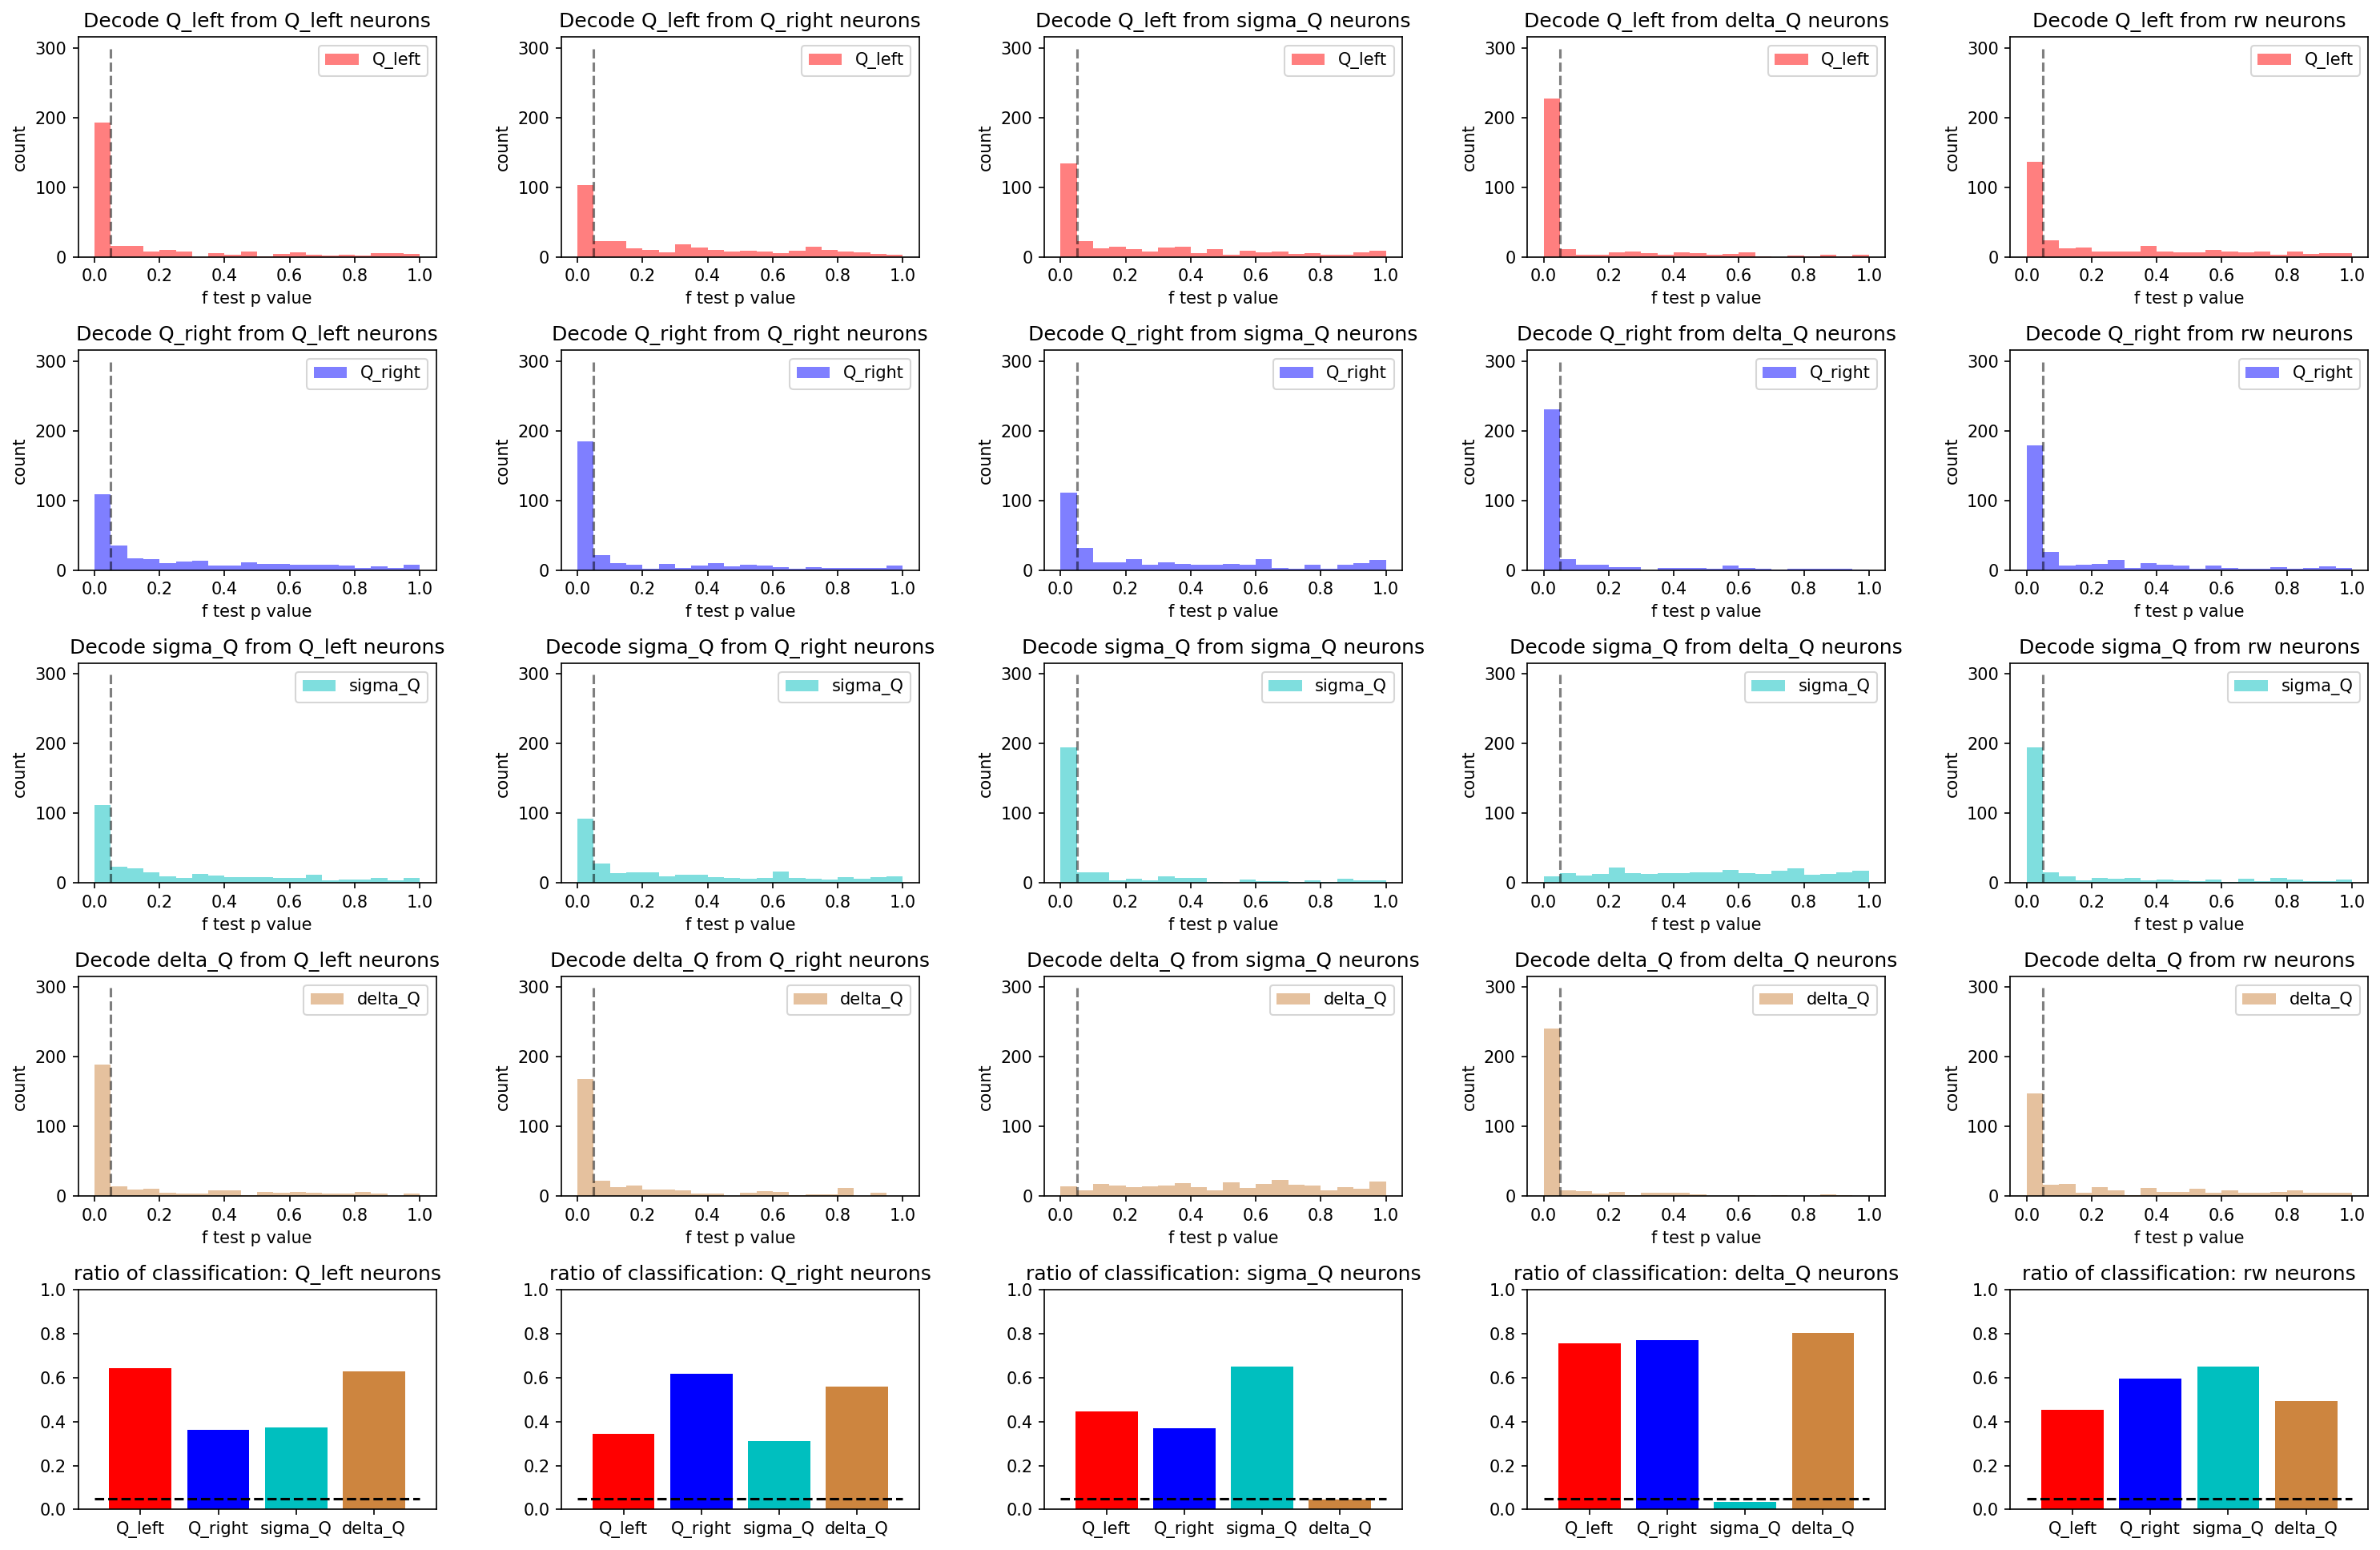

In [48]:
# plot std fit, single neuron decoding

# hist plot
colors = {'Q_left': 'r', 'Q_right': 'b', 'sigma_Q': 'c', 'delta_Q': 'peru'}
pvlaue_hist_lim = (0, 1)
pvalue_sig_thresh = 0.05

# bar plot
classified_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
bar_colors = ['r', 'b', 'c', 'peru']


fig, axs = plt.subplots(len(target_variables)+1, len(neuron_types), 
                        figsize=(4*len(neuron_types), 3*len(target_variables)+1),
                        dpi=150)
for neuron_type_id, neuron_type in enumerate(neuron_types):
    col_ind = neuron_type_id

    df_fit = df_std_decode_dict[neuron_type]
    n_unique_neurons = len(np.unique(df_fit['neuron_id'].values))
    
    n_sig_neurons = {target_variable: None for target_variable in target_variables}
    for i, target_variable in enumerate(target_variables):
        
        # histogram of regression tvalues
        row_ind = i
        ftest_pvalues = df_fit[df_fit['target_variable']==target_variable]['ftest_pvalue'].values
        hist_q_side, _, _ = axs[row_ind, col_ind].hist(ftest_pvalues, bins=20, range=pvlaue_hist_lim, histtype='stepfilled', 
                                                       color=colors[target_variable], label=target_variable, alpha=0.5)
        axs[row_ind, col_ind].vlines(pvalue_sig_thresh, 0, n_unique_neurons, 
                                     color='k', linestyle='--', alpha=0.5)

        axs[row_ind, col_ind].set_title(f'Decode {target_variable} from {neuron_type} neurons')
        axs[row_ind, col_ind].set_xlabel('f test p value')
        axs[row_ind, col_ind].set_ylabel('count')
        axs[row_ind, col_ind].legend()

        # for ratio of significant neurons
        n_sig_neurons[target_variable] = np.sum(ftest_pvalues < 0.05)


    # bar plot for significant neurons
    row_ind = len(target_variables)
    classified_ratios = [n_sig_neurons[target_variable]/ float(n_unique_neurons) for target_variable in target_variables]
    
    axs[row_ind, col_ind].bar(classified_types, classified_ratios, color=bar_colors)
    x_lim = axs[row_ind, col_ind].get_xlim()
    axs[row_ind, col_ind].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'ratio of decodability: {neuron_type} neurons')
    axs[row_ind, col_ind].set_ylim(0, 1)

plt.tight_layout()

In [20]:
# std fit, poppulation decoding
target_variables = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']

std_decode_pop_columns = ['gen_session', 'neuron_ids', 'fit_session', 'target_variable', 'ftest_pvalue']
df_std_decode_pop_dict = {neuron_type: pd.DataFrame(columns=std_decode_pop_columns) for neuron_type in neuron_types}

n_simulations = 200
n_neuron_in_population = 20

# fit simulated neurons
for neuron_type in neuron_types:
    print(f'region {neuron_type}')
    neurons = sim_neurons[neuron_type]
    sessions_with_unit = np.unique(neurons['session'].values)

    df_std_fit = df_std_decode_pop_dict[neuron_type]

    for session in sessions_with_unit:
        neurons_session = neurons[neurons['session']==session]
        
        df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
        for target_variable in target_variables:
            if target_variable in ['Q_left', 'Q_right']:
                X = df_Qs_session[[target_variable]]
            elif target_variable == 'sigma_Q':
                X = df_Qs_session[['Q_left']].values + df_Qs_session[['Q_right']].values
            elif target_variable == 'delta_Q':
                X = df_Qs_session[['Q_left']].values - df_Qs_session[['Q_right']].values
            else:
                raise ValueError('incorrect target variable type!')
            #print(f' sess {session}, target {target_variable}: {X.shape}')
            
            for n_sim in range(n_simulations):
                neuron_ids = np.random.choice(np.arange(0, len(neurons)), size=n_neuron_in_population, replace=False)
                fr = np.empty((X.shape[0], n_neuron_in_population))
                for j, neuron_id in enumerate(neuron_ids):
                    fr[:, j] = neurons[(neurons['session']==session) & (neurons['neuron_id']==neuron_id)]['firing_rates'].values[0]
                fr = sm.add_constant(fr)
                # decoding models: fr --> X
                model = sm.OLS(X, fr)
                results = model.fit()
                #print(f'{neuron_type} {n} {target_variable}')
                #print(f' {results.f_pvalue}')
                df_std_fit.loc[len(df_std_fit.index)] = [session, neuron_ids, session, target_variable, results.f_pvalue]

session 38


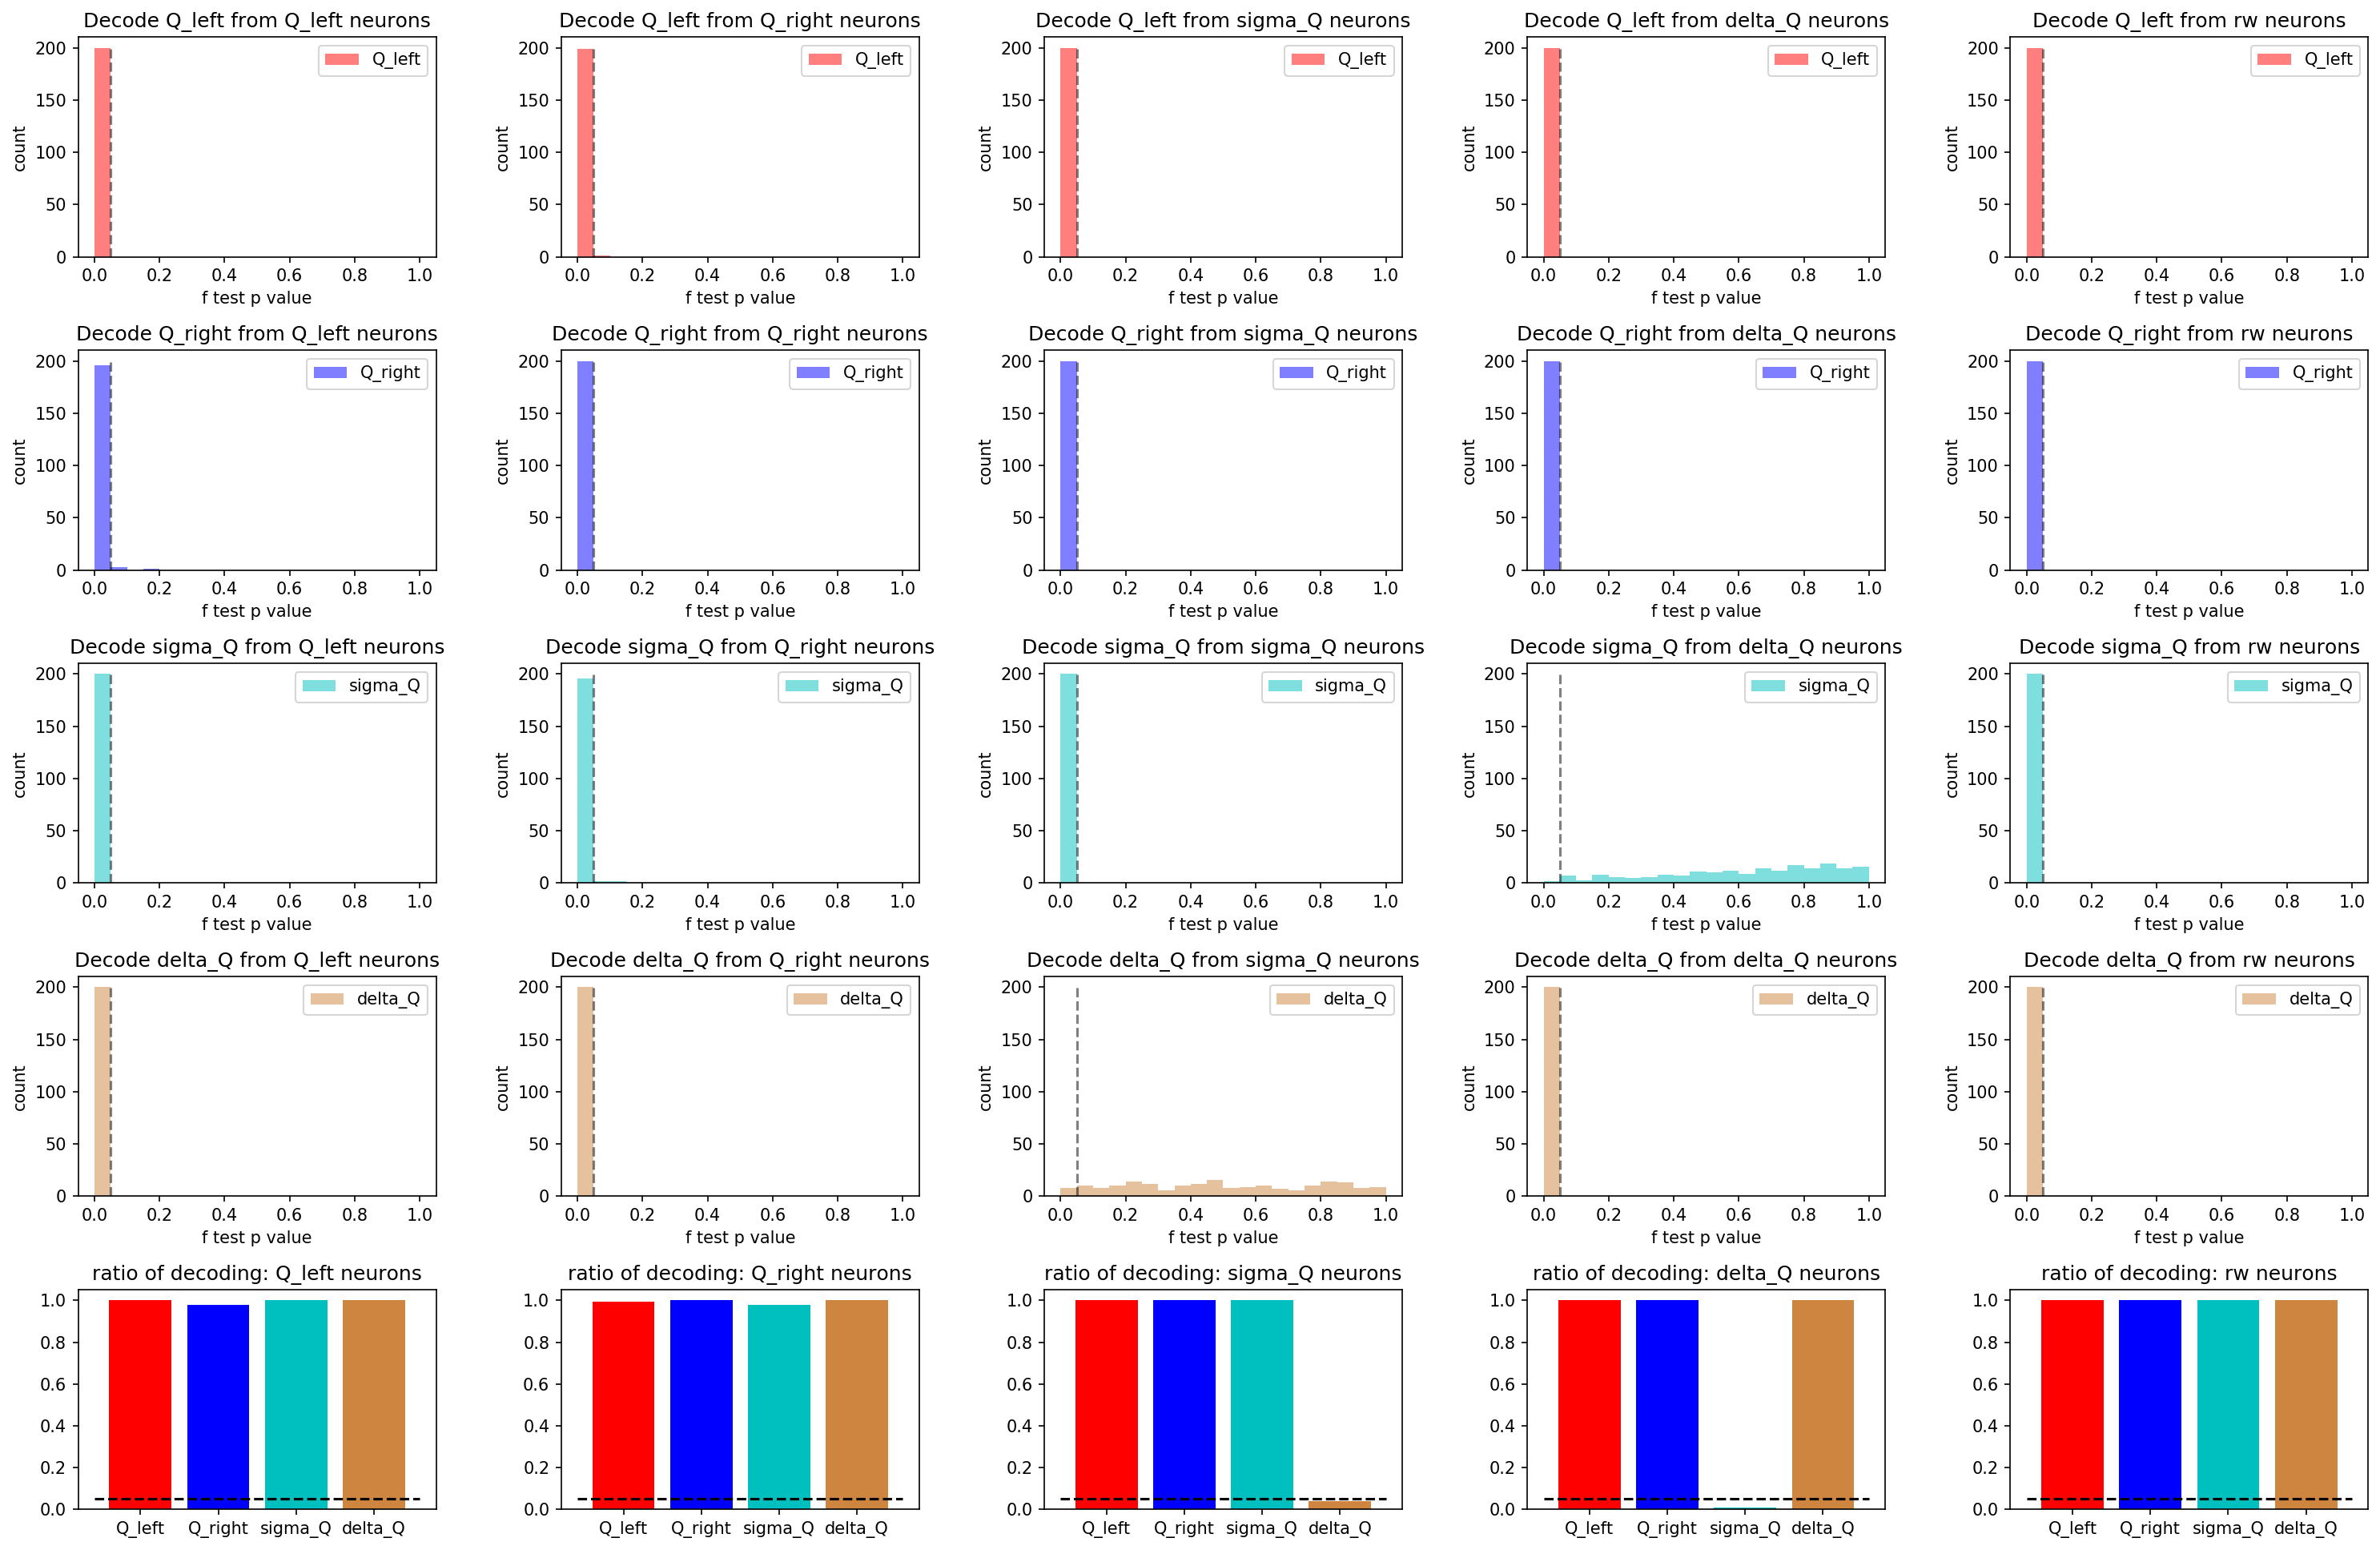

In [26]:
# plot naive fit of population neurons
colors = {'Q_left': 'r', 'Q_right': 'b', 'sigma_Q': 'c', 'delta_Q': 'peru'}
pvlaue_hist_lim = (0, 1)
pvalue_sig_thresh = 0.05

classified_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
bar_colors = ['r', 'b', 'c', 'peru']


fig, axs = plt.subplots(len(target_variables)+1, len(neuron_types), 
                        figsize=(4*len(neuron_types), 3*len(target_variables)+1), dpi=150)
for neuron_type_id, neuron_type in enumerate(neuron_types):
    col_ind = neuron_type_id

    df_fit = df_naive_fit_population_dict[neuron_type]
    n_unique_populations = n_simulations
    
    n_sig_populations = {target_variable: None for target_variable in target_variables}
    for i, target_variable in enumerate(target_variables):
        
        # histogram of regression tvalues
        row_ind = i
        ftest_pvalues = df_fit[df_fit['target_variable']==target_variable]['ftest_pvalue'].values
        hist_q_side, _, _ = axs[row_ind, col_ind].hist(ftest_pvalues, bins=20, range=pvlaue_hist_lim, histtype='stepfilled', 
                                                       color=colors[target_variable], label=target_variable, alpha=0.5)
        axs[row_ind, col_ind].vlines(pvalue_sig_thresh, 0, n_unique_populations, 
                                     color='k', linestyle='--', alpha=0.5)

        axs[row_ind, col_ind].set_title(f'Decode {target_variable} from {neuron_type} neurons')
        axs[row_ind, col_ind].set_xlabel('f test p value')
        axs[row_ind, col_ind].set_ylabel('count')
        axs[row_ind, col_ind].legend()

        # for ratio of significant neurons
        n_sig_populations[target_variable] = np.sum(ftest_pvalues < 0.05)


    # bar plot for significant neurons
    row_ind = len(target_variables)
    classified_ratios = [n_sig_populations[target_variable]/ float(n_unique_populations) for target_variable in target_variables]
    
    axs[row_ind, col_ind].bar(classified_types, classified_ratios, color=bar_colors)
    x_lim = axs[row_ind, col_ind].get_xlim()
    axs[row_ind, col_ind].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'ratio of decoding: {neuron_type} neurons')
    axs[row_ind, col_ind].set_ylim(0, 1.05)

plt.tight_layout()

### Multi-session PERMUTATION method

In [4]:
subject_id = 482353
model_id = 10
q_latent_variable = (foraging_model.FittedSessionModel.TrialLatentVariable 
                    & {'subject_id': subject_id, 
                       'model_id': model_id})

df_Q = pd.DataFrame(q_latent_variable.fetch())
df_Q_left = df_Q[df_Q['water_port']=='left']#.sort_values(by=['trial'])
df_Q_right = df_Q[df_Q['water_port']=='right']#.sort_values(by=['trial'])

# get only Qs columns
df_Q_right = df_Q_right[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_right'})#.reset_index(drop=True)
df_Q_left = df_Q_left[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_left'})#.reset_index(drop=True)
df_Qs = df_Q_left.merge(df_Q_right)

# select sessions
sessions_all = np.unique(df_Qs['session'].values)
print(f'total sessions: {len(sessions_all)}, {sessions_all}')

n_session_to_ana = 5
manual_selection = True
if manual_selection:
    sessions = [38, 39, 40, 42, 45]
else:
    sessions = np.random.choice(sessions_all, size=n_session_to_ana)
print(f'selected sessions for ana: {sessions}')

# get min session length
session_len = []
for session in sessions:
    df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
    session_len.append(len(df_Qs_session))

print(f'min session {session_len.index(min(session_len))} len: {min(session_len)}, max session {session_len.index(max(session_len))} len: {max(session_len)}')
len_min = min(session_len)

total sessions: 45, [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
selected sessions for ana: [38, 39, 40, 42, 45]
min session 0 len: 468, max session 3 len: 1143


In [14]:
# generate simulated neurons
n_neurons = 2
neuron_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q', 'rw']

sim_neuron_columns = ['session', 'neuron_id', 'firing_rates']
sim_neurons = {neuron_type: pd.DataFrame(columns=sim_neuron_columns) for neuron_type in neuron_types}

for n in range(n_neurons):

    for gen_session in sessions:
        df_Qs_session = df_Qs[df_Qs['session']==gen_session].sort_values(by=['trial'])
        X = df_Qs_session[['Q_left', 'Q_right']]
        #print(f'session {gen_session}: {X.shape}')

        for neuron_type in neuron_types:
            if neuron_type in ['Q_left', 'Q_right']:
                fr = gen_action_value_neuron(X[neuron_type].values)
            elif neuron_type == 'sigma_Q':
                fr = gen_action_value_neuron(X['Q_left'].values + X['Q_right'].values)
            elif neuron_type == 'delta_Q':
                fr = gen_action_value_neuron(X['Q_left'].values - X['Q_right'].values)
            elif neuron_type == 'rw':
                fr = gen_random_walk_neuron(len(X))
            else:
                raise ValueError('wrong neuron types!')
            sim_neurons[neuron_type].loc[len(sim_neurons[neuron_type].index)] = [gen_session, n, fr]

In [20]:
# multi_session_permutation fit
# compute the test statistic: avg t values of regression
# in all possible permutations
target_variables = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
msp_fit_columns = ['gen_session_perm', 'neuron_id', 'fit_session_perm', 'target_variable', 'ftest_pvalue']
df_msp_fit_dict = {neuron_type: pd.DataFrame(columns=msp_fit_columns) for neuron_type in neuron_types}

# fit on all permutations of sessions
# single neuron, present in all sessions

for j, p in enumerate(itertools.permutations(range(len(sessions)))):
    print(f'permutation {j}: {p}')
    
    for neuron_type in neuron_types:
        neurons = sim_neurons[neuron_type]
        df_msp_fit = df_msp_fit_dict[neuron_type]
        
        for n in range(n_neurons):
            for target_variable in target_variables:
                gen_session_perm = []
                fit_session_perm = []
                ftest_pvalues = []

                for session_id in range(len(sessions)):
                    gen_session = sessions[session_id]
                    fit_session = sessions[p[session_id]]
                    gen_session_perm.append(gen_session)
                    fit_session_perm.append(fit_session)
                    # print(f' using gen_session {gen_session} and fit_session {fit_session}')

                    # get Qs
                    df_Qs_session = df_Qs[df_Qs['session']==fit_session].sort_values(by=['trial'])
                    if target_variable in ['Q_left', 'Q_right']:
                        X = df_Qs_session[[target_variable]][:len_min]
                    elif target_variable == 'sigma_Q':
                        X = (df_Qs_session[['Q_left']].values + df_Qs_session[['Q_right']].values)[:len_min]
                    elif target_variable == 'delta_Q':
                        X = (df_Qs_session[['Q_left']].values - df_Qs_session[['Q_right']].values)[:len_min]
                    else:
                        raise ValueError('incorrect target variable type!')

                    fr = neurons[(neurons['session']==gen_session) & 
                                 (neurons['neuron_id']==n)]['firing_rates'].values[0][:len_min]
                    fr = sm.add_constant(fr)
                    # decoding models: fr --> X
                    model = sm.OLS(X, fr)
                    results = model.fit()
                    #print(f'{neuron_type} {n} {target_variable}')
                    #print(f' {results.f_pvalue}')
                    ftest_pvalues.append(results.f_pvalue)
                
                ftest_pvalues = np.array(ftest_pvalues)
                df_msp_fit.loc[len(df_msp_fit.index)] = [gen_session_perm, n, fit_session_perm, 
                                                        target_variable, ftest_pvalues]

permutation 0: (0, 1, 2, 3, 4)
permutation 1: (0, 1, 2, 4, 3)
permutation 2: (0, 1, 3, 2, 4)
permutation 3: (0, 1, 3, 4, 2)
permutation 4: (0, 1, 4, 2, 3)
permutation 5: (0, 1, 4, 3, 2)
permutation 6: (0, 2, 1, 3, 4)
permutation 7: (0, 2, 1, 4, 3)
permutation 8: (0, 2, 3, 1, 4)
permutation 9: (0, 2, 3, 4, 1)
permutation 10: (0, 2, 4, 1, 3)
permutation 11: (0, 2, 4, 3, 1)
permutation 12: (0, 3, 1, 2, 4)
permutation 13: (0, 3, 1, 4, 2)
permutation 14: (0, 3, 2, 1, 4)
permutation 15: (0, 3, 2, 4, 1)
permutation 16: (0, 3, 4, 1, 2)
permutation 17: (0, 3, 4, 2, 1)
permutation 18: (0, 4, 1, 2, 3)
permutation 19: (0, 4, 1, 3, 2)
permutation 20: (0, 4, 2, 1, 3)
permutation 21: (0, 4, 2, 3, 1)
permutation 22: (0, 4, 3, 1, 2)
permutation 23: (0, 4, 3, 2, 1)
permutation 24: (1, 0, 2, 3, 4)
permutation 25: (1, 0, 2, 4, 3)
permutation 26: (1, 0, 3, 2, 4)
permutation 27: (1, 0, 3, 4, 2)
permutation 28: (1, 0, 4, 2, 3)
permutation 29: (1, 0, 4, 3, 2)
permutation 30: (1, 2, 0, 3, 4)
permutation 31: (1

In [21]:
df_msp_fit_dict['rw']

,gen_session_perm,neuron_id,fit_session_perm,target_variable,ftest_pvalue
0,"[38, 39, 40, 42, 45]",0,"[38, 39, 40, 42, 45]",Q_left,"[0.8472847579208083, 0.8264830165866983, 0.081..."
1,"[38, 39, 40, 42, 45]",0,"[38, 39, 40, 42, 45]",Q_right,"[0.00287312683730903, 0.48255650727045063, 1.2..."
2,"[38, 39, 40, 42, 45]",0,"[38, 39, 40, 42, 45]",sigma_Q,"[0.0021515902891444927, 0.7065118235735134, 4...."
3,"[38, 39, 40, 42, 45]",0,"[38, 39, 40, 42, 45]",delta_Q,"[0.11640425233620208, 0.62906862317876, 2.8882..."
4,"[38, 39, 40, 42, 45]",1,"[38, 39, 40, 42, 45]",Q_left,"[0.6543469622350115, 0.5711256208882839, 0.048..."
...,...,...,...,...,...
955,"[38, 39, 40, 42, 45]",0,"[45, 42, 40, 39, 38]",delta_Q,"[0.30964710312429683, 0.14623548128463562, 2.8..."
956,"[38, 39, 40, 42, 45]",1,"[45, 42, 40, 39, 38]",Q_left,"[0.013954661429236043, 3.832390117154225e-09, ..."
957,"[38, 39, 40, 42, 45]",1,"[45, 42, 40, 39, 38]",Q_right,"[0.27564175145802056, 0.00021346857938243626, ..."
958,"[38, 39, 40, 42, 45]",1,"[45, 42, 40, 39, 38]",sigma_Q,"[0.07075639870598731, 0.00011874031013320481, ..."


In [ ]:
# plot multi_session_permutation fit
colors = {'Q_left': 'r', 'Q_right': 'b', 'sigma_Q': 'c', 'delta_Q': 'peru'}
pvlaue_hist_lim = (0, 1)
pvalue_sig_thresh = 0.05

classified_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
bar_colors = ['r', 'b', 'c', 'peru']


fig, axs = plt.subplots(len(target_variables)+1, len(neuron_types), 
                        figsize=(4*len(neuron_types), 3*len(target_variables)+1), dpi=150)
for neuron_type_id, neuron_type in enumerate(neuron_types):
    col_ind = neuron_type_id

    df_fit = df_msp_fit_dict[neuron_type]
    n_unique_neurons = len(np.unique(df_fit['neuron_id'].values))
    #tvalues_percentile = {'Q_left': None, 'Q_right': None}
    
    n_sig_neurons = {target_variable: None for target_variable in target_variables}
    for i, target_variable in enumerate(target_variables):
        
        for n in np.unique(df_fit['neuron_id'].values).astype(np.int):
            df_fit_neuron = df_fit[df_fit['neuron_id']==n]
            tvalues_q_side = np.vstack(df_fit_neuron[f'tvalues_{q_side}'].values[:]).astype(np.float)
            avg_tvalues_q_side = np.average(tvalues_q_side, axis=1)
            # get self fitted permutation
            tvalue_self_q_side = df_fit_neuron[df_fit_neuron['gen_session_perm']==df_fit_neuron['fit_session_perm']][f'tvalues_{q_side}'].iloc[0]
            avg_tvalue_self_q_side = np.average(tvalue_self_q_side)
            
            t_percentile_agnt_null.append(stats.percentileofscore(avg_tvalues_q_side, avg_tvalue_self_q_side))

        # histogram of regression tvalues
        row_ind = i
        ftest_pvalues = df_fit[df_fit['target_variable']==target_variable]['ftest_pvalue'].values
        hist_q_side, _, _ = axs[row_ind, col_ind].hist(ftest_pvalues, bins=20, range=pvlaue_hist_lim, histtype='stepfilled', 
                                                       color=colors[target_variable], label=target_variable, alpha=0.5)
        axs[row_ind, col_ind].vlines(pvalue_sig_thresh, 0, n_unique_neurons, 
                                     color='k', linestyle='--', alpha=0.5)

        axs[row_ind, col_ind].set_title(f'Decode {target_variable} from {neuron_type} neurons')
        axs[row_ind, col_ind].set_xlabel('f test p value')
        axs[row_ind, col_ind].set_ylabel('count')
        axs[row_ind, col_ind].legend()

        # for ratio of significant neurons
        n_sig_neurons[target_variable] = np.sum(ftest_pvalues < 0.05)


    # bar plot for significant neurons
    row_ind = len(target_variables)
    classified_ratios = [n_sig_neurons[target_variable]/ float(n_unique_neurons) for target_variable in target_variables]
    
    axs[row_ind, col_ind].bar(classified_types, classified_ratios, color=bar_colors)
    x_lim = axs[row_ind, col_ind].get_xlim()
    axs[row_ind, col_ind].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'ratio of classification: {neuron_type} neurons')
    axs[row_ind, col_ind].set_ylim(0, 1)

plt.tight_layout()

### Pseudo sessio method

In [5]:
def get_block_lengths(p_reward_trial, p_reward_block):
    block_switch_trial = [0]
    for block_ind in range(p_reward_block.shape[1]):
        trials = np.where((p_reward_trial[0] == p_reward_block[0, block_ind]) & 
                          (p_reward_trial[1] == p_reward_block[1, block_ind]) &
                          [False if t<block_switch_trial[-1] else True for t in range(p_reward_trial.shape[1])])[0]
        # print(f'{block_ind}: {trials}')
        # print(f' {np.where(np.diff(trials) > 1)}')
        if len(np.where(np.diff(trials) > 1)[0])>0:
            trials_first_switch_ind = np.where(np.diff(trials) > 1)[0][0] + 1
            block = trials[: trials_first_switch_ind]
        else:
            block = trials
        # print(f' {block}')
        block_switch_trial.append(block[-1]+1)
    
    block_switch_trial = np.array(block_switch_trial)
    block_lengths = np.diff(block_switch_trial)

    return block_lengths, block_switch_trial


def gen_p_reward_sequence(p_reward_trial, p_reward_block, block_lengths, 
                          block_generator_spread=5, seed=None, plot=False):
    
    p_reward_gen = np.empty((p_reward_trial.shape[0], p_reward_trial.shape[1]+1))
    #print(f'p_reward_block shape: {p_reward_block.shape}')
    #print(f'p_reward_gen shape: {p_reward_gen.shape}')

    # generate new block lengths
    if seed:
        np.random.seed(seed)
    
    not_all_positive = True
    while not_all_positive:
        block_length_generator = np.rint(np.random.uniform(
                                            -1*block_generator_spread+0.1, 
                                            block_generator_spread+0.1, 
                                            size=len(block_lengths)-1)).astype(np.int)
        block_length_generator = np.append(block_length_generator, -1*np.sum(block_length_generator))
        block_lengths_gen = (block_lengths + block_length_generator).astype(np.int)
        not_all_positive = np.any(block_lengths_gen<=0)
        
    #print(f'original block lengths: {block_lengths}')
    #print(f'generated new block length: {block_lengths_gen}')
    #print(f'check total trial number: {np.sum(block_lengths_gen)}')
    
    # generate new p_reward arr
    for i in range(p_reward_trial.shape[0]):
        for block_gen_ind in range(len(block_lengths_gen)):
            if block_gen_ind == 0:
                p_reward_gen[i, 0:block_lengths_gen[block_gen_ind]] = p_reward_block[i, block_gen_ind]
            else:
                t_start = np.sum(block_lengths_gen[:block_gen_ind])
                p_reward_gen[i, t_start:t_start+block_lengths_gen[block_gen_ind]] = p_reward_block[i, block_gen_ind]
        p_reward_gen[i, -1] = p_reward_gen[i, -2]

    if plot:
        sides = ['left', 'right']
        colors = ['r', 'b']
        plt.figure(figsize=(8,4), dpi=150)
        for i in range(p_reward_trial.shape[0]):
            plt.plot(p_reward_trial[i], color=colors[i], label=f'original {sides[i]}')
            plt.plot(p_reward_gen[i], color=colors[i], linestyle='--', label=f'generated {sides[i]}')
            plt.title(f'Generated reward rate blocks')
            plt.xlabel('trial')
            plt.ylabel('reward_rate')
        plt.legend(bbox_to_anchor=(1, 0.6))
        plt.tight_layout()
            
    return p_reward_gen, block_lengths_gen

In [6]:
def gen_qs_by_fitted_model(key, p_reward_trial, p_reward_block, block_lengths, 
                           block_generator_spread=5, forager_type='LNP_softmax'):
    
    # get fitted model
    model_para = pd.DataFrame((foraging_model.FittedSessionModel.Param & key).fetch())
    model_para_dict = {}
    for i in range(len(model_para)):
        model_para_dict[model_para.iloc[i]['model_param']] = model_para.iloc[i]['fitted_value']
        
    forager = bandit_model.BanditModel(forager=forager_type, n_trials=int((p_reward_trial).shape[1]), 
                                    **model_para_dict)
    #for k, v in vars(forager).items():
    #    if v is not None:
    #        print(f'{k}: {v}')

    # generate reward sequence
    p_reward_gen, block_lengths_gen = gen_p_reward_sequence(p_reward_trial, p_reward_block, block_lengths, 
                                                            block_generator_spread=block_generator_spread, plot=False)
    forager.n_blocks = len(block_lengths)
    forager.p_reward = p_reward_gen
    forager.block_size = block_lengths_gen
    forager.p_reward_fraction = p_reward_gen[1]/ np.sum(p_reward_gen, axis=0)
    forager.p_reward_ratio = p_reward_gen[1]/ p_reward_gen[0]
    #for k, v in vars(forager).items():
    #    if v is not None:
    #        print(f'{k}: {v}')

    # generative mode
    # Initialization
    forager.time = 0

    # All latent variables have n_trials + 1 length to capture the update after the last trial (HH20210726)
    forager.q_estimation = np.full([forager.K, forager.n_trials+1], np.nan)
    forager.q_estimation[:, 0] = 0

    forager.choice_prob = np.full([forager.K, forager.n_trials+1], np.nan)
    forager.choice_prob[:, 0] = 1/forager.K   # To be strict (actually no use)

    forager.choice_history = np.zeros(
                    [1, forager.n_trials+1], dtype=int)  # Choice history
    # Reward history, separated for each port (Corrado Newsome 2005)
    forager.reward_history = np.zeros([forager.K, forager.n_trials+1])

    forager.reward_available = np.zeros([forager.K, forager.n_trials+1])
    forager.reward_available[:, 0] = (np.random.uniform(0, 1, forager.K) < forager.p_reward[:, forager.time]).astype(int)

    if forager.forager in ['LNP_softmax', 'LNP_softmax_CK']:
        # Compute the history filter. Compatible with any number of taus.
        # Use the full length of the session just in case of an extremely large tau.
        reversed_t = np.flipud(np.arange(forager.n_trials+1))
        forager.history_filter = np.zeros_like(reversed_t).astype('float64')
        for tau, w_tau in zip(forager.taus, forager.w_taus):
            # Note the normalization term (= tau when n -> inf.)
            forager.history_filter += w_tau * \
                                    np.exp(-reversed_t / tau) / \
                                    np.sum(np.exp(-reversed_t / tau))

    for t in range(forager.n_trials):
        action = forager.act()
        forager.step(action)
    #for k, v in vars(forager).items():
    #    if v is not None:
    #        print(f'{k}: {v}')
    
    return forager.q_estimation

In [7]:
# generate session action-reward sequence
key = {'subject_id': 482353, 'session': 38, 'model_id': 10}
sessions = [key['session']]

# get fitted q variables
q_latent_variable = (foraging_model.FittedSessionModel.TrialLatentVariable & key)

df_Q = pd.DataFrame(q_latent_variable.fetch())
df_Q_left = df_Q[df_Q['water_port']=='left']#.sort_values(by=['trial'])
df_Q_right = df_Q[df_Q['water_port']=='right']#.sort_values(by=['trial'])

# get only Qs columns
df_Q_right = df_Q_right[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_right'})#.reset_index(drop=True)
df_Q_left = df_Q_left[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_left'})#.reset_index(drop=True)
df_Qs = df_Q_left.merge(df_Q_right)


# get session history
p_reward_block_df = pd.DataFrame((experiment.SessionBlock.WaterPortRewardProbability() & key).fetch())
p_reward_block_left = p_reward_block_df[p_reward_block_df['water_port']=='left'].sort_values(by='block')['reward_probability'].values
p_reward_block_right = p_reward_block_df[p_reward_block_df['water_port']=='right'].sort_values(by='block')['reward_probability'].values
p_reward_block = np.vstack((p_reward_block_left, p_reward_block_right)).astype(np.float)

blocks = np.unique(p_reward_block_df['block'].values)
if np.max(blocks) != len(blocks):
    raise ValueError('missing blocks!')
else:
    n_blocks = len(blocks)

choice_history, reward_history, _, p_reward_trial, q_choice_outcome = foraging_model.get_session_history(key, remove_ignored=True)
block_lengths, _ = get_block_lengths(p_reward_trial, p_reward_block)

In [ ]:
q_est = gen_qs_by_fitted_model(key, p_reward_trial, p_reward_block, block_lengths, block_generator_spread=0)

In [ ]:
# plot q_estimation
qs = ['Q_left', 'Q_right']
colors = ['r', 'b']
fig, axs = plt.subplots(2,1, figsize=(6,6), dpi=150)
for i, q in enumerate(qs):
    axs[0].plot(df_Qs[df_Qs['session']==key['session']][q].values, color=colors[i], label=q)
    axs[1].plot(q_est[i], color=colors[i], label=q)
axs[0].set_title('Original Q values')
axs[1].set_title('Generated Q values')
for j in range(len(axs)):
    axs[j].set_xlabel('trial')
    axs[j].set_ylabel('Q_value')
    axs[j].legend(loc='best')
plt.tight_layout()